# Undistorting a single LiDAR point cloud

Load data

In [1]:
import rosbag

bag = rosbag.Bag("/home/harry7557558/fast_lio_ws/bag/utias/2024-02-21-13-06-52.bag")

messages = {}
for topic, msg, msg_t in bag.read_messages():
    if topic not in messages:
        messages[topic] = []
    messages[topic].append(msg)

livox_imu = messages['/livox/imu']
livox_lidar = messages['/livox/lidar']

bag.close()

print(len(livox_imu))
print(len(livox_lidar))


2158
108


Interpolate IMU data

In [2]:
import numpy as np
from scipy.interpolate import CubicSpline

angular_velocities = np.array([[msg.angular_velocity.x, msg.angular_velocity.y, msg.angular_velocity.z] for msg in livox_imu])
linear_accelerations = 9.81 * np.array([[msg.linear_acceleration.x, msg.linear_acceleration.y, msg.linear_acceleration.z] for msg in livox_imu])

# Extract timestamps from IMU messages
timestamps_raw = np.array([msg.header.stamp.to_sec() for msg in livox_imu])
timestamps = timestamps_raw - timestamps_raw[0]

# Create cubic spline interpolations for angular velocity and linear acceleration
angular_interp = CubicSpline(timestamps, angular_velocities, axis=0)
linear_interp = CubicSpline(timestamps, linear_accelerations, axis=0)

# Get timestamp of point cloud
def get_cloud_time(lidar_msg):
    points = sorted(lidar_msg.points, key=lambda _: _.offset_time)
    time_start = lidar_msg.header.stamp.to_sec()
    # points = [p for p in points if timestamps_raw[0]<=time_start+1e-9*p.offset_time<=timestamps_raw[-1]]
    times = 1e-9 * np.array([p.offset_time for p in points])
    return time_start + times - timestamps_raw[0]

Plot IMU

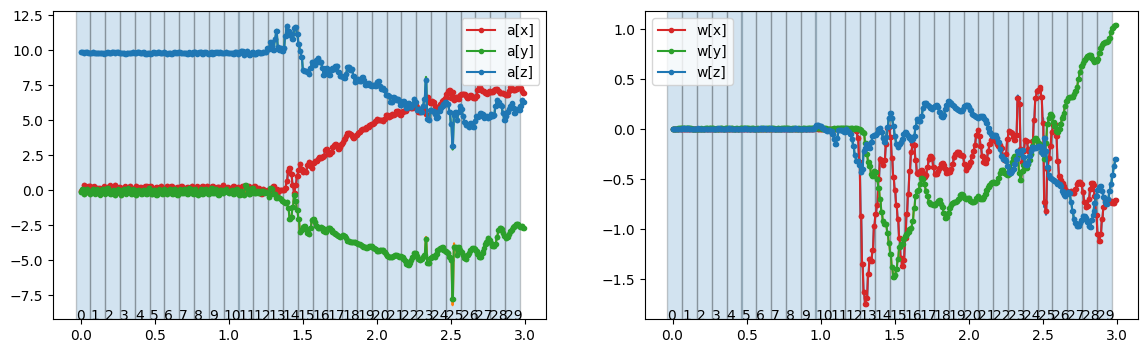

In [276]:
import matplotlib.pyplot as plt

n = min(len(timestamps), 600)
nl = n // 20
ts = np.linspace(timestamps[0], timestamps[n-1], 10*n)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
ax1.plot(ts, linear_interp(ts)[:,0])
ax1.plot(timestamps[:n], linear_accelerations[:n,0], 'C3.-', label='a[x]')
ax1.plot(ts, linear_interp(ts)[:,1])
ax1.plot(timestamps[:n], linear_accelerations[:n,1], 'C2.-', label='a[y]')
ax1.plot(ts, linear_interp(ts)[:,2])
ax1.plot(timestamps[:n], linear_accelerations[:n,2], 'C0.-', label='a[z]')
for i in range(nl):
    tr = get_cloud_time(livox_lidar[i])
    ax1.axvspan(tr[0], tr[-1], lw=1, alpha=0.2, edgecolor='k')
    ax1.annotate(str(i), (tr[0], ax1.get_ylim()[0]))
ax1.legend()
ax2.plot(ts, angular_interp(ts)[:,0])
ax2.plot(timestamps[:n], angular_velocities[:n,0], 'C3.-', label='w[x]')
ax2.plot(ts, angular_interp(ts)[:,1])
ax2.plot(timestamps[:n], angular_velocities[:n,1], 'C2.-', label='w[y]')
ax2.plot(ts, angular_interp(ts)[:,2])
ax2.plot(timestamps[:n], angular_velocities[:n,2], 'C0.-', label='w[z]')
for i in range(nl):
    tr = get_cloud_time(livox_lidar[i])
    ax2.axvspan(tr[0], tr[-1], lw=1, alpha=0.2, edgecolor='k')
    ax2.annotate(str(i), (tr[0], ax2.get_ylim()[0]))
ax2.legend()
plt.show()

Integrate for local velocity

In [319]:
def exp_so3_(phi):
    theta = np.fmax(np.linalg.norm(phi), 1e-12)
    n = phi / theta
    nnT = np.outer(n, n)
    n_star = np.array([[0.0, -n[2], n[1]], [n[2], 0.0, -n[0]], [-n[1], n[0], 0.0]])
    R = np.cos(theta) * np.eye(3) + \
        (1.0-np.cos(theta)) * nnT + \
        np.sin(theta) * n_star
    assert np.linalg.norm(R@R.T-np.eye(3)) < 1e-12
    return R

def exp_so3(phi):
    theta = np.linalg.norm(phi, axis=1).reshape((-1,1))
    theta = np.fmax(theta, 1e-12*np.ones_like(theta))
    n = phi / theta
    nnT = np.einsum('ki,kj->kij', n, n)
    n_star = np.zeros_like(nnT)
    n_star[:,0,1] = -n[:,2]
    n_star[:,0,2] = n[:,1]
    n_star[:,1,0] = n[:,2]
    n_star[:,1,2] = -n[:,0]
    n_star[:,2,0] = -n[:,1]
    n_star[:,2,1] = n[:,0]
    I = np.eye(3).reshape((-1,3,3)).repeat(len(theta),axis=0)
    theta = theta.reshape((-1,1,1))
    R = np.cos(theta) * I + \
        (1.0-np.cos(theta)) * nnT + \
        np.sin(theta) * n_star
    if True:
        residual = np.einsum('nij,nkj->nik', R, R) - I
        assert (np.linalg.norm(residual, axis=(1,2)) < 1e-12).all()
    return R

phi = np.random.normal(size=(10, 3))
# exp_so3_(phi[2])
exp_so3(phi).shape

(10, 3, 3)

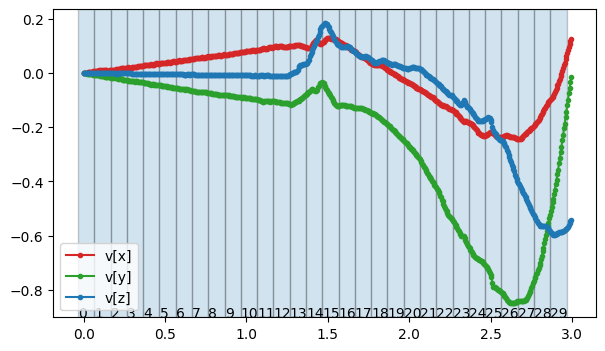

In [320]:
vg = np.zeros(3)
R = np.eye(3)
prev_t = timestamps[0]
linear_velocities = [vg]
for t, al, wl in zip(timestamps[1:], linear_accelerations[1:], angular_velocities[1:]):
    n_step = 1
    for i in range(n_step):
        ag = R @ al - [0,0,9.81]
        wg = R @ wl
        dt = (t-prev_t)/n_step
        vg = vg + ag * dt
        R = exp_so3([wl*dt])[0] @ R
    vl = R.T @ vg
    linear_velocities.append(vl)
    prev_t = t
linear_velocities = np.array(linear_velocities)


fig, ax1 = plt.subplots(1, 1, figsize=(7, 4))
ax1.plot(timestamps[:n], linear_velocities[:n,0], 'C3.-', label='v[x]')
ax1.plot(timestamps[:n], linear_velocities[:n,1], 'C2.-', label='v[y]')
ax1.plot(timestamps[:n], linear_velocities[:n,2], 'C0.-', label='v[z]')
for i in range(nl):
    tr = get_cloud_time(livox_lidar[i])
    ax1.axvspan(tr[0], tr[-1], lw=1, alpha=0.2, edgecolor='k')
    ax1.annotate(str(i), (tr[0], ax1.get_ylim()[0]))
ax1.legend()
plt.show()

Downsample point cloud

In [5]:
from plyfile import PlyData, PlyElement

def write_point_cloud(points, filename):
    vertex = np.array([(x, y, z) for x, y, z in points], dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4')])
    vertex_element = PlyElement.describe(vertex, 'vertex')
    PlyData([vertex_element], text=False).write(filename)


def downsample_point_cloud_with_time(times, points):

    bmax = np.amax(points, 0)
    bmin = np.amin(points, 0)
    bbox_size = bmax - bmin
    size = np.prod(bbox_size)**(1/3)

    voxel_size = np.fmax((120*bbox_size/size+0.5).astype(np.int32), 1)
    # print(voxel_size)
    pids = -1 * np.ones(voxel_size, dtype=np.int32)
    pdists = np.inf * np.ones(voxel_size, dtype=np.float32)

    for i, p in enumerate(points):
        g = (p-bmin)/(bmax-bmin) * voxel_size
        g = np.fmin(g, voxel_size-0.001)
        gi = g.astype(np.int32)
        gd = np.linalg.norm(g-gi-0.5)
        if gd < pdists[gi[0], gi[1], gi[2]]:
            pids[gi[0], gi[1], gi[2]] = i
            pdists[gi[0], gi[1], gi[2]] = gd

    times1 = []
    points1 = []
    for p0, p1, p2 in zip(*np.where(pids >= 0)):
        i = pids[p0, p1, p2]
        times1.append(times[i])
        points1.append(points[i])
    return np.array(times1), np.array(points1)


def get_cloud(lidar_msg, id=-1, sort=True):
    points = sorted(lidar_msg.points, key=lambda _: _.offset_time)
    time_start = lidar_msg.header.stamp.to_sec()
    times = 1e-9 * np.array([p.offset_time for p in points])
    points = np.array([(p.x, p.y, p.z) for p in points])
    if id >= 0:
        write_point_cloud(points, "{:04d}-raw.ply".format(id))
    # print(times.shape, points.shape)
    times_d, points_d = downsample_point_cloud_with_time(times, points)
    # print(times.shape, points.shape)
    if id >= 0:
        write_point_cloud(points, "{:04d}-raw.ply".format(id))
        write_point_cloud(points_d, "{:04d}-downsampled.ply".format(id))
        # print cloud shape to see if it's right
        mean = np.mean(points_d, axis=0)
        cov = np.linalg.svd(np.cov(points_d.T))[1]**0.5
        print(id, mean, cov)
    
    if sort:
        i = np.argsort(times_d)
        times_d, points_d = times_d[i], points_d[i]
    return times_d, points_d


_ = get_cloud(livox_lidar[1], 1)
_ = get_cloud(livox_lidar[12], 12)
_ = get_cloud(livox_lidar[13], 13)
_ = get_cloud(livox_lidar[14], 14)
_ = get_cloud(livox_lidar[18], 18)
_ = get_cloud(livox_lidar[29], 29)


1 [-0.63462617 -0.12941414  1.71955218] [2.82366347 2.23324904 1.06722564]
12 [-0.15407046 -0.34527914  1.84173474] [2.54475285 2.12295994 0.96927754]
13 [-0.23961829 -0.76144558  1.88428435] [2.63051597 2.21665854 0.96800286]
14 [-0.16721852 -1.08113515  1.86454983] [2.75464092 2.27618397 1.01304785]
18 [ 0.16089352 -1.40001063  1.79924651] [3.08247487 2.3443156  1.1442621 ]
29 [ 0.95786526 -0.64736638  1.56281731] [2.2453438  2.04737113 0.87347909]


Undistort using IMU

v: [-0.02769897 -0.33691456 -0.5887267 ]
w: [-0.85491951  0.84284399 -0.64505655]


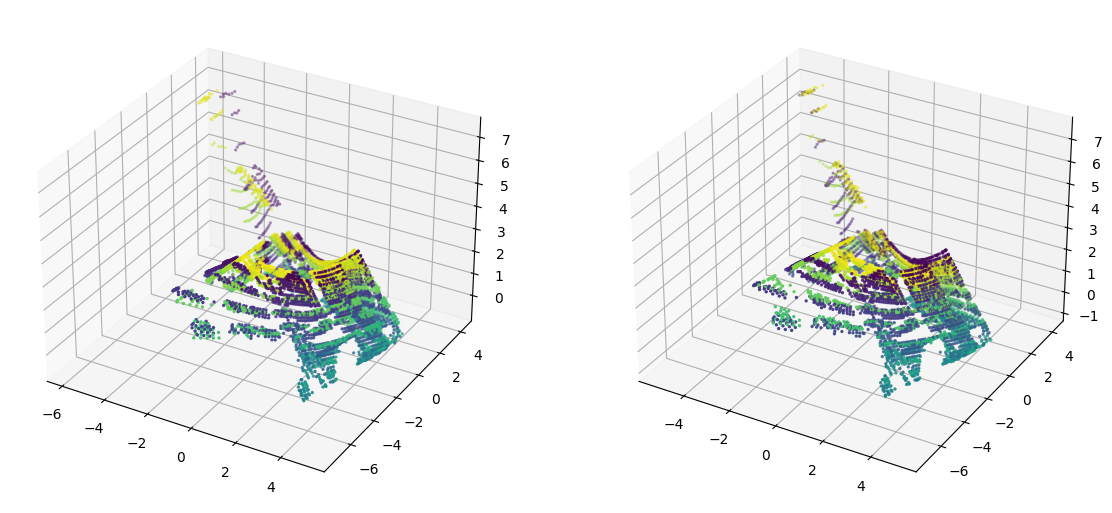

In [322]:
scan = livox_lidar[29]
ts_g = get_cloud_time(scan)
imu_i = np.where((timestamps >= min(ts_g)) & (timestamps <= max(ts_g)))

ts, ps = get_cloud(scan)


v = np.mean(linear_velocities[imu_i], axis=0)
w = np.mean(angular_velocities[imu_i], axis=0)
print('v:', v)
print('w:', w)

%matplotlib tk
%matplotlib inline

Rs = exp_so3(np.outer(ts, w))
us = np.einsum('kij,kj->ki', Rs, ps) + np.outer(ts, v)

fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.scatter(ps[:,0], ps[:,1], ps[:,2], s=2, c=ts, cmap=plt.get_cmap('viridis'))
ax2.scatter(us[:,0], us[:,1], us[:,2], s=2, c=ts, cmap=plt.get_cmap('viridis'))
plt.show()


Normal calculation test

mean error: 0.010274799730416785


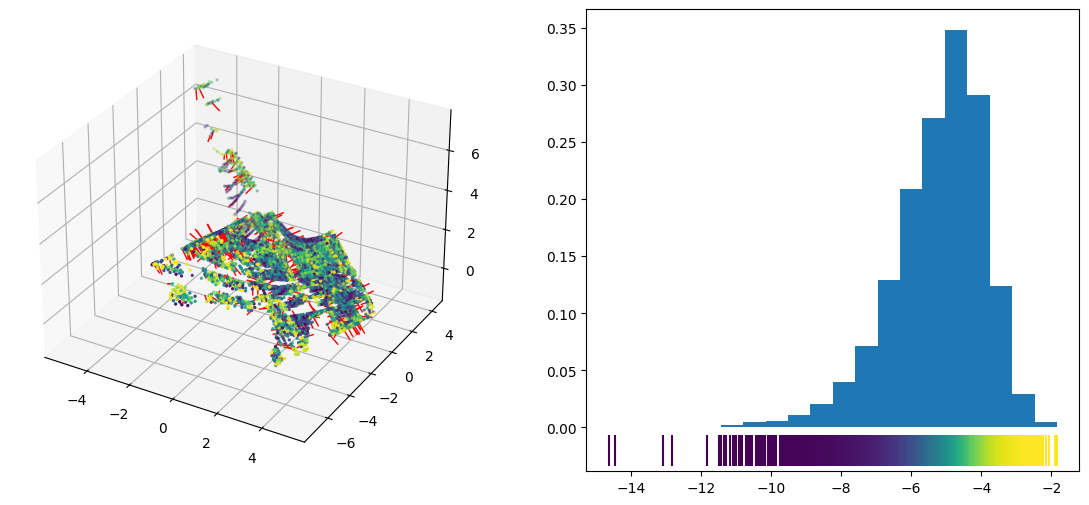

In [169]:
from scipy.spatial import KDTree

def calc_planes(us, nk=6):
    tree = KDTree(us)
    distances, indices = tree.query(us, k=nk)
    neighbors = us[indices]
    lsqr_A = np.concatenate((neighbors, np.ones((*indices.shape, 1))), axis=2)
    lsqr_ATA = np.transpose(lsqr_A, axes=(0,2,1)) @ lsqr_A
    eigenvalues, eigenvectors = np.linalg.eigh(lsqr_ATA)
    min_eigenvalue_index = np.argmin(eigenvalues, axis=-1)
    min_eigenvectors = eigenvectors[np.arange(eigenvectors.shape[0]), :, min_eigenvalue_index]
    planes = min_eigenvectors / np.linalg.norm(min_eigenvectors[:,:3], axis=1, keepdims=True)
    return planes

def plot_plane_error(us):
    planes = calc_planes(us)
    normals = planes[:, :3]
    residuals = (normals * us).sum(1) + planes[:, 3]
    errors = np.abs(residuals)
    log_errors = np.log(errors)

    print('mean error:', np.mean(errors))

    fig = plt.figure(figsize=(14, 6))

    # plot normals
    ax1 = fig.add_subplot(121, projection='3d')
    error_scale = (log_errors-np.amin(log_errors))/(np.amax(log_errors)-np.amin(log_errors))
    error_scale[np.argsort(log_errors)] = np.linspace(0,1,len(errors))
    sc = ax1.scatter(us[:,0], us[:,1], us[:,2], s=2, c=error_scale, cmap=plt.get_cmap('viridis'))
    for u, n, re in list(zip(us, normals, error_scale))[::11]:
        l = np.concatenate((u, u+0.5*n)).reshape(2, 3)
        ax1.plot(l[:,0], l[:,1], l[:,2], 'r', linewidth=1)

    # plot projection error
    ax2 = fig.add_subplot(122)
    ax2.hist(np.log(errors), bins=20, density=True)
    ax2.scatter(log_errors, 0.0*errors-0.02, marker='|', s=500, c=error_scale, cmap=plt.get_cmap('viridis'))

    plt.show()

%matplotlib tk
%matplotlib inline

plot_plane_error(us)


Undistort using optimization, stuck

In [325]:
import scipy.optimize

def fun(params):
    v, w = params[0:3], params[3:6]
    Rs = exp_so3(np.outer(ts, w))
    us = np.einsum('kij,kj->ki', Rs, ps) + np.outer(ts, v)
    planes = calc_planes(us)
    residuals = (planes[:, :3] * us).sum(1) + planes[:, 3]
    err = np.mean(np.abs(residuals))
    # print(err)
    return err

params_init = np.concatenate((v, w))
print("initial error:", fun(params_init))

# print(scipy.optimize.check_grad(lambda _: fun(_)[0], lambda _: fun(_)[1], T))
# assert False

method = 'Nelder-Mead'
# method = 'Powell'
# method = 'BFGS'

# res = scipy.optimize.minimize(fun, params_init, method=method)
# print('success', res.success, 'nit', res.nit, 'nfev', res.nfev)
# print("final error:", res.fun)
# v, w = res.x[0:3], res.x[3:6]
# print('v:', v)
# print('w:', w)

initial error: 0.9333217208323311


Iterative "smoothing"

mean error: 0.0017401399886014261


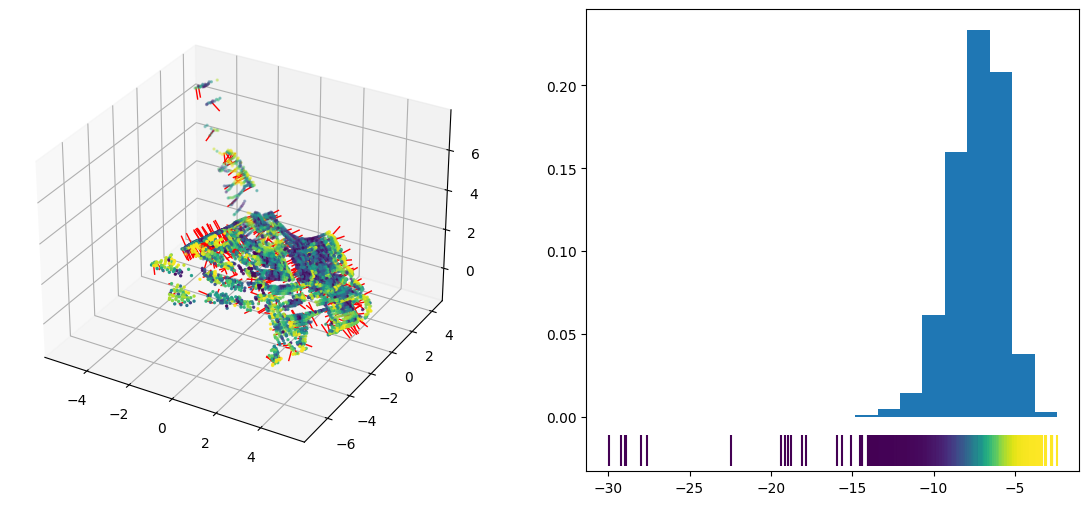

In [260]:
ss = np.array(us)

for i in range(5):
    planes = calc_planes(ss)
    n, d = planes[:,0:3], planes[:,3]
    ss = ss - ((ss*n).sum(1)+d).reshape((-1,1)) * n

%matplotlib tk
%matplotlib inline

plot_plane_error(ss)


Map $p\rightarrow s$, minimize for $\exp((\omega_0+\omega_1t)^\land)p + (v_0+v_1t) \sim s$

v guess: [-0.02769897 -0.33691456 -0.5887267 ]
w guess: [-0.85491951  0.84284399 -0.64505655]
rmse before: 0.015500026032890482
(nfev, njev): 3 3
rmse after: 0.015336959823539005
v: [-0.0083112  -0.26790121 -0.51465085]
w: [-0.85027963  0.8498903  -0.6553557 ]
mean error: 0.009680569973575973


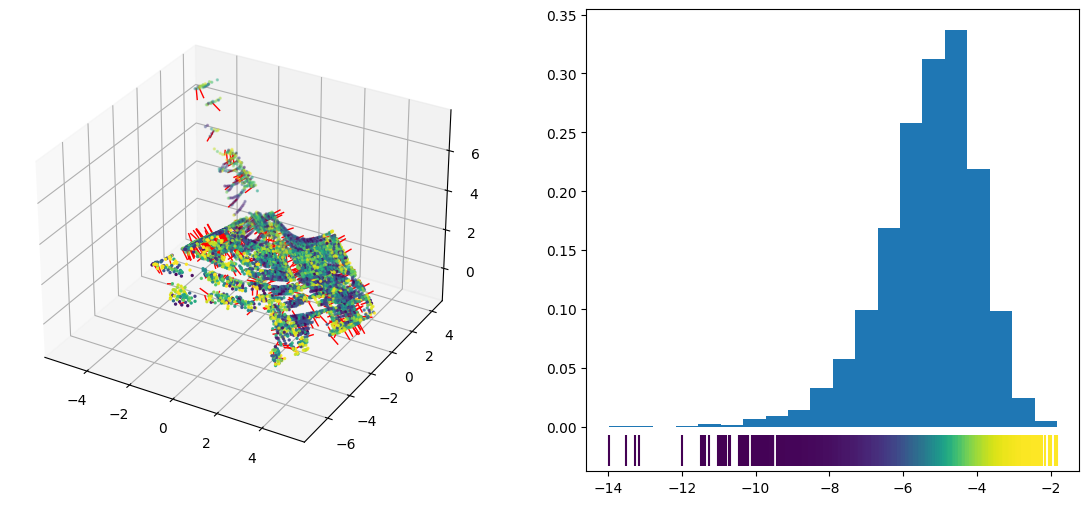

In [330]:
def fun(params):
    v0, v1 = params[0:3], params[3:6]
    w0, w1 = params[6:9], params[9:12]
    Rs = exp_so3(w0.reshape((-1,3)) + np.outer(ts, w1))
    vs = v0.reshape((1,3)) + np.outer(ts,v1)
    ss1 = np.einsum('kij,kj->ki', Rs, ps) + vs
    residual = (ss1 - ss).flatten()
    # return residual
    delta = 0.05
    qr_residual = np.sign(residual) * np.sqrt(delta*np.fmax(2.0*np.abs(residual)-delta, 0.0))
    return residual + (qr_residual-residual) * (np.abs(residual) > delta)

v = np.mean(linear_velocities[imu_i], axis=0)
w = np.mean(angular_velocities[imu_i], axis=0)
print('v guess:', v)
print('w guess:', w)
params_guess = np.concatenate((np.zeros(3), v, np.zeros(3), w))

print('rmse before:', np.mean(fun(params_guess)**2)**0.5)
res = scipy.optimize.least_squares(
    fun, params_guess,
    verbose=0, x_scale='jac', ftol=1e-4, method='trf')
print('(nfev, njev):', res.nfev, res.njev)
print('rmse after:', np.mean(res.fun**2)**0.5)

params = res.x
v0, v1 = params[0:3], params[3:6]
w0, w1 = params[6:9], params[9:12]
print('v:', v1)
print('w:', w1)

w0, v0 = w0*0.0, v0*0.0
Rs = exp_so3(w0.reshape((-1,3)) + np.outer(ts, w1))
vs = v0.reshape((1,3)) + np.outer(ts,v1)
fs = np.einsum('kij,kj->ki', Rs, ps) + vs
plot_plane_error(fs)

higher degree polynomial

v guess: [-0.02769897 -0.33691456 -0.5887267 ]
w guess: [-0.85491951  0.84284399 -0.64505655]
rmse before: 0.08084769409462092
(nfev, njev): 5 5
rmse after: 0.015315572423811985
cv:
[[-0.07115165 -0.35703184 -0.56151188]
 [-0.05647926 -0.25924826 -0.49853497]
 [ 0.02347671  0.04096006 -0.0782017 ]
 [ 0.09190214 -0.00714733 -0.02464709]]
cw:
[[-8.49253565e-01  8.53023636e-01 -6.43950362e-01]
 [-8.35058293e-01  8.68554406e-01 -6.67125871e-01]
 [ 7.76609724e-03 -1.29391814e-02 -3.41480982e-04]
 [-2.09360301e-02 -3.34980444e-02  1.99968522e-02]]
mean error: 0.00961852445511134


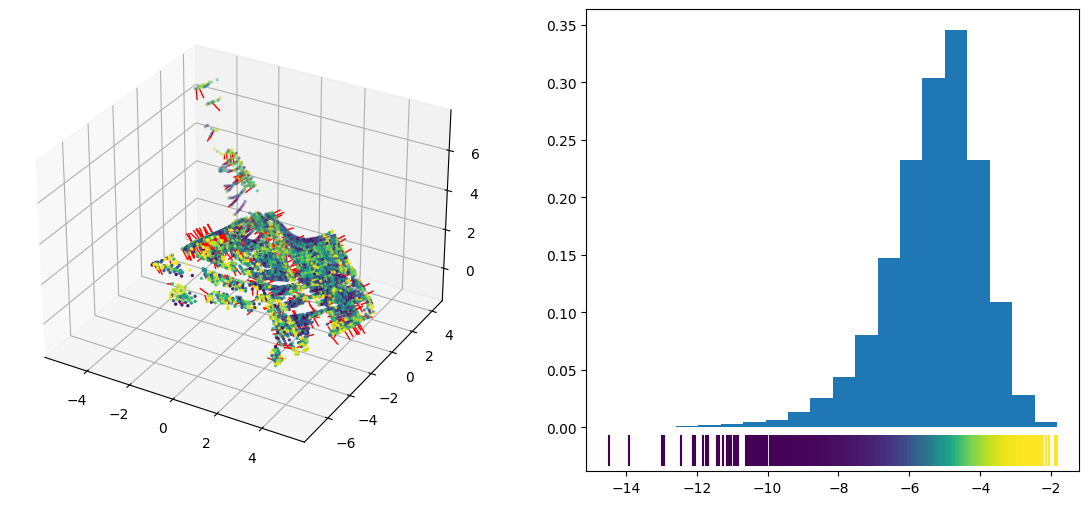

In [332]:
ts_normalized = -1.0 + 2.0 * (ts-np.amin(ts)) / (np.amax(ts)-np.amin(ts))

deg_v = 3
deg_w = 3

def eval_v_w(params, ts):
    cv = params[:3*(deg_v+1)].reshape((-1, 3))
    cw = params[3*(deg_v+1):].reshape((-1, 3))
    vs = np.zeros((len(ts),3))
    for i in range(deg_v+1):
        vs += np.outer(ts**i, cv[i])
    ws = np.zeros((len(ts),3))
    for i in range(deg_w+1):
        ws += np.outer(ts**i, cw[i])
    return vs, ws

def fun(params):
    vs, ws = eval_v_w(params, ts_normalized)
    ss1 = np.einsum('kij,kj->ki', exp_so3(ws), ps) + vs
    residual = (ss1 - ss).flatten()
    # return residual
    delta = 0.05
    qr_residual = np.sign(residual) * np.sqrt(delta*np.fmax(2.0*np.abs(residual)-delta, 0.0))
    return residual + (qr_residual-residual) * (np.abs(residual) > delta)

v = np.mean(linear_velocities[imu_i], axis=0)
w = np.mean(angular_velocities[imu_i], axis=0)
normalizer = 2.0 / (np.amax(ts)-np.amin(ts))
print('v guess:', v)
print('w guess:', w)
params_guess = np.concatenate((
    np.zeros(3), v/normalizer, np.zeros(3*(deg_v-1)),
    np.zeros(3), w/normalizer, np.zeros(3*(deg_w-1))
    ))

print('rmse before:', np.mean(fun(params_guess)**2)**0.5)
res = scipy.optimize.least_squares(
    fun, params_guess,
    verbose=0, x_scale='jac', ftol=1e-4, method='trf')
print('(nfev, njev):', res.nfev, res.njev)
print('rmse after:', np.mean(res.fun**2)**0.5)

params = res.x
cv = params[:3*(deg_v+1)].reshape((-1, 3))
cw = params[3*(deg_v+1):].reshape((-1, 3))
print('cv:', cv*normalizer, 'cw:', cw*normalizer, sep='\n')

vs, ws = eval_v_w(params, ts_normalized)
fs = np.einsum('kij,kj->ki', exp_so3(ws), ps) + vs
plot_plane_error(fs)

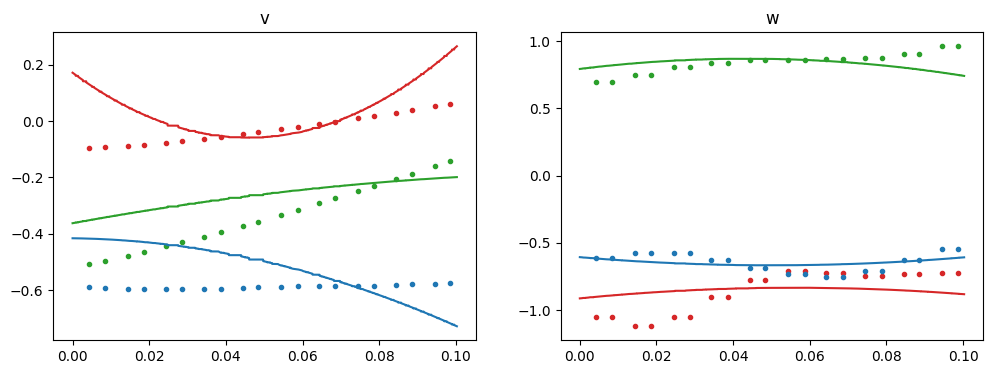

In [335]:
fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(121)
vs_imu = linear_velocities[imu_i]
for i, c in enumerate(['C3', 'C2', 'C0']):
    ax1.plot(timestamps[imu_i]-min(ts_g), vs_imu[:,i], c+'.')
    ax1.plot(ts, np.gradient(vs[:,i])/np.gradient(ts), c+'-')

ax2 = fig.add_subplot(122)
ws_imu = angular_velocities[imu_i]
for i, c in enumerate(['C3', 'C2', 'C0']):
    ax2.plot(timestamps[imu_i]-min(ts_g), ws_imu[:,i], c+'.')
    ax2.plot(ts, np.gradient(ws[:,i])/np.gradient(ts), c+'-')

ax1.set_title('v')
ax2.set_title('w')
plt.show()